In [1]:
import pandas as pd
import warnings    
warnings.filterwarnings('ignore')

df_1 = pd.read_csv(r'C:\Users\filip\Downloads\archive\used_cars_data.csv')

In [67]:
# 1. Amostragem de 100 mil linhas
sample_df = df_1.sample(n=300000, random_state=42)

In [68]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import RareLabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

initial_cols = ['price', 'body_type', 'city', 'daysonmarket', 'engine_type', 'exterior_color', 
                 'frame_damaged', 'franchise_dealer', 'fuel_type', 'has_accidents', 
                 'horsepower', 'interior_color', 'is_new', 'year', 'major_options', 
                 'make_name', 'model_name', 'maximum_seating', 'mileage', 'seller_rating', 
                 'theft_title', 'torque', 'transmission_display', 'trim_name', 'wheel_system_display']
df = sample_df
                
item0 = df.shape[0]  
df = df.drop_duplicates()  # Remove as duplicatas
item1 = df.shape[0]  
print(f"Tem {item0-item1} duplicatas no dataset")  # Verifica se há duplicatas

# remove linhas com preço menor ou igual a zero
df = df[df['price']>0]

# transforma a variável target em log10
df['log10_price'] = df['price'].apply(lambda x: np.log10(x))

# converte a variável 'major_options' em número de opções
for col in ['exterior_color', 'interior_color', 'make_name', 'model_name']:
    df[col] = df[col].fillna('None').str.lower()

# combina make_name e model_name
df['model'] = df['make_name'] + ' ' + df['model_name']



selected_cols = ['log10_price', 'model', 'body_type', 'city', 'daysonmarket', 'engine_type', 
                 'exterior_color', 'frame_damaged', 'franchise_dealer', 'fuel_type', 'has_accidents', 
                 'horsepower', 'interior_color', 'is_new', 'year', 'major_options', 
                 'maximum_seating', 'mileage', 'seller_rating', 
                 'theft_title', 'torque', 'transmission_display', 'trim_name', 
                 'wheel_system_display']
df = df[selected_cols]


Tem 1 duplicatas no dataset


In [69]:
# Função para log-transform das colunas numéricas
def log10_transform(x):
    try:
        return np.log10(x + 1)
    except:
        return np.nan

# Função para bin-transform da coluna seller_rating
def bin_transform(x):
    try:
        return round(1/10 * round(x * 10), 1)
    except:
        return np.nan

# Aplicar log10-transform nas colunas numéricas
for col in ['mileage', 'daysonmarket', 'horsepower']:
    df[f'log10_{col}'] = df[col].apply(log10_transform)
    df = df.drop([col], axis=1)

# Aplicar bin-transform na coluna seller_rating
df['seller_rating'] = df['seller_rating'].apply(bin_transform)

# Remover colunas irrelevantes
cols2drop = ['major_options', 'torque']
df = df.drop(cols2drop, axis=1)

# Aplicar RareLabelEncoder nas colunas categóricas
for col in df.columns:
    if col != 'log10_price' and df[col].dtype == 'object':
        df[col] = df[col].fillna('None').astype(str)
        encoder = RareLabelEncoder(n_categories=1, max_n_categories=150, replace_with='Other', tol=50/df.shape[0])
        df[col] = encoder.fit_transform(df[[col]])

# Exibir a forma do DataFrame pós-transformação
print(df.shape)
print(df.head())


(299999, 22)
         log10_price               model        body_type     city  \
80798       4.172895      chevrolet trax  SUV / Crossover    Other   
46643       4.597969       jeep cherokee  SUV / Crossover    Other   
2145423     4.146066       nissan sentra            Sedan    Tulsa   
1134021     4.268321       nissan sentra            Sedan  Atlanta   
1852268     4.414973  chevrolet traverse  SUV / Crossover    Other   

        engine_type                   exterior_color frame_damaged  \
80798            I4                     summit white          None   
46643            V6  diamond black crystal pearlcoat          None   
2145423          I4                             gray         False   
1134021          I4                     gun metallic          None   
1852268          V6            mosaic black metallic         False   

         franchise_dealer fuel_type has_accidents  ...  year  maximum_seating  \
80798                True  Gasoline          None  ...  2020    

In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
log10_price,299999.0,4.404600,0.260128,2.397940,4.266467,4.423115,4.582518,6.518513
year,299999.0,2017.729226,4.174447,1915.000000,2017.000000,2020.000000,2020.000000,2021.000000
seller_rating,295962.0,4.271941,0.513680,1.000000,4.000000,4.300000,4.600000,5.000000
log10_mileage,285566.0,2.831507,1.967494,0.000000,0.845098,3.906093,4.638826,8.000000
log10_daysonmarket,299999.0,1.555291,0.570470,0.000000,1.176091,1.568202,1.919078,3.464788
log10_horsepower,282812.0,2.368209,0.156869,1.819544,2.245513,2.389166,2.480007,2.977724


In [71]:
# Função para dropar linhas que contenham 'Other' em colunas categóricas
def drop_other_rows(df):
    """
    Remove linhas que contenham a categoria 'Other' em qualquer coluna categórica.
    
    Parâmetros:
    df (pd.DataFrame): O DataFrame a ser filtrado.
    
    Retorna:
    pd.DataFrame: DataFrame filtrado sem 'Other' em colunas categóricas.
    """
    for col in df.select_dtypes(include=['object']).columns:
        df = df[df[col] != 'Other']  # Excluir as linhas onde 'Other' está presente
    return df

# Aplicar a função para remover linhas com 'Other'
df = drop_other_rows(df)

# Exibir a forma do DataFrame pós-transformação
print(df.shape)
print(df.head())


(35655, 22)
         log10_price             model        body_type         city  \
2145423     4.146066     nissan sentra            Sedan        Tulsa   
1134021     4.268321     nissan sentra            Sedan      Atlanta   
2398243     4.255224     jeep wrangler  SUV / Crossover       Austin   
2932591     4.041353  chevrolet impala            Sedan  Los Angeles   
2451632     3.889302       honda civic            Sedan       Dallas   

        engine_type exterior_color frame_damaged  franchise_dealer fuel_type  \
2145423          I4           gray         False             False  Gasoline   
1134021          I4   gun metallic          None              True  Gasoline   
2398243          I6            red         False             False  Gasoline   
2932591          I4           gray         False             False  Gasoline   
2451632          I4         maroon         False             False  Gasoline   

        has_accidents  ...  year  maximum_seating  seller_rating theft_tit

In [72]:
df.nunique()

log10_price             16148
model                     143
body_type                   9
city                      150
engine_type                20
exterior_color            149
frame_damaged               3
franchise_dealer            2
fuel_type                   7
has_accidents               3
interior_color            139
is_new                      2
year                       32
maximum_seating             9
seller_rating              34
theft_title                 3
transmission_display       25
trim_name                 150
wheel_system_display        6
log10_mileage           16453
log10_daysonmarket        595
log10_horsepower          176
dtype: int64

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35655 entries, 2145423 to 622026
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   log10_price           35655 non-null  float64
 1   model                 35655 non-null  object 
 2   body_type             35655 non-null  object 
 3   city                  35655 non-null  object 
 4   engine_type           35655 non-null  object 
 5   exterior_color        35655 non-null  object 
 6   frame_damaged         35655 non-null  object 
 7   franchise_dealer      35655 non-null  bool   
 8   fuel_type             35655 non-null  object 
 9   has_accidents         35655 non-null  object 
 10  interior_color        35655 non-null  object 
 11  is_new                35655 non-null  bool   
 12  year                  35655 non-null  int64  
 13  maximum_seating       35655 non-null  object 
 14  seller_rating         35271 non-null  float64
 15  theft_title      

In [74]:
df = df.drop(['model','city','exterior_color','interior_color','trim_name','transmission_display','theft_title','wheel_system_display', 'body_type'], axis=1)


In [75]:
# Função para extrair o número de assentos e converter para int
def extract_seating(seating_str):
    try:
        # Remove a palavra 'seats' e converte para inteiro
        return int(seating_str.split(' ')[0])
    except:
        # Se houver algum erro, retorna NaN
        return np.nan

# Aplicar a função à coluna 'maximum_seating' para transformar em inteiro
df['maximum_seating'] = df['maximum_seating'].apply(extract_seating)

# Verificar se a conversão foi bem-sucedida
print(df['maximum_seating'].head())

# Opcional: Imputar valores faltantes (NaN) se houver algum
df['maximum_seating'].fillna(df['maximum_seating'].median(), inplace=True)

# Verificar novamente a coluna
print(df['maximum_seating'].head())


2145423    5.0
1134021    5.0
2398243    4.0
2932591    5.0
2451632    5.0
Name: maximum_seating, dtype: float64
2145423    5.0
1134021    5.0
2398243    4.0
2932591    5.0
2451632    5.0
Name: maximum_seating, dtype: float64


In [76]:
df['engine_type'].value_counts()

engine_type
I4                      20732
V6                       7656
V8                       2047
None                     1042
V6 Flex Fuel Vehicle      868
V8 Flex Fuel Vehicle      757
I3                        693
I4 Hybrid                 637
H4                        607
I6 Diesel                 241
V8 Biodiesel              111
I4 Flex Fuel Vehicle       98
V6 Biodiesel               50
I5                         44
I6                         20
V8 Diesel                  19
V6 Diesel                  17
V6 Hybrid                  10
I4 Diesel                   4
V10                         2
Name: count, dtype: int64

In [77]:
df['fuel_type'].value_counts()


fuel_type
Gasoline             31801
Flex Fuel Vehicle     1723
None                   915
Hybrid                 647
Diesel                 281
Biodiesel              161
Electric               127
Name: count, dtype: int64

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35655 entries, 2145423 to 622026
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   log10_price         35655 non-null  float64
 1   engine_type         35655 non-null  object 
 2   frame_damaged       35655 non-null  object 
 3   franchise_dealer    35655 non-null  bool   
 4   fuel_type           35655 non-null  object 
 5   has_accidents       35655 non-null  object 
 6   is_new              35655 non-null  bool   
 7   year                35655 non-null  int64  
 8   maximum_seating     35655 non-null  float64
 9   seller_rating       35271 non-null  float64
 10  log10_mileage       34037 non-null  float64
 11  log10_daysonmarket  35655 non-null  float64
 12  log10_horsepower    33723 non-null  float64
dtypes: bool(2), float64(6), int64(1), object(4)
memory usage: 3.3+ MB


In [79]:
from sklearn.preprocessing import LabelEncoder

# 1. Aplicar Label Encoding nas colunas categóricas 'engine_type' e 'fuel_type'
label_encoder = LabelEncoder()

for col in ['engine_type', 'fuel_type']:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Verificar a transformação
print(df[['engine_type', 'fuel_type']].head())




         engine_type  fuel_type
2145423            2          4
1134021            2          4
2398243            7          4
2932591            2          4
2451632            2          4


In [80]:
# 2. Converter colunas booleanas (True/False) para 0 e 1
boolean_cols = ['franchise_dealer', 'is_new']
df[boolean_cols] = df[boolean_cols].astype(int)

# Verificar as colunas transformadas
print(df[boolean_cols].head())

# Exibir a forma do DataFrame pós-transformação
print(df.shape)

         franchise_dealer  is_new
2145423                 0       0
1134021                 1       1
2398243                 0       0
2932591                 0       0
2451632                 0       0
(35655, 13)


In [81]:
import numpy as np

# Função para converter 'True' em 1, 'False' em 0, e 'None' em NaN
def boolean_transform(value):
    if value == 'True':
        return 1
    elif value == 'False':
        return 0
    else:
        return np.nan  # Mantém o valor como NaN se for None

# Aplicar a transformação para as colunas 'frame_damaged' e 'has_accidents'
for col in ['frame_damaged', 'has_accidents']:
    df[col] = df[col].apply(boolean_transform)

# Verificar as primeiras linhas das colunas transformadas
print(df[['frame_damaged', 'has_accidents']].head())

# Opcional: Imputar os valores NaN posteriormente
# Aqui podemos preencher os valores faltantes (NaN) com a moda (valor mais frequente)
df['frame_damaged'].fillna(df['frame_damaged'].mode()[0], inplace=True)
df['has_accidents'].fillna(df['has_accidents'].mode()[0], inplace=True)

# Verificar novamente após preenchimento de NaNs
print(df[['frame_damaged', 'has_accidents']].head())


         frame_damaged  has_accidents
2145423            0.0            0.0
1134021            NaN            NaN
2398243            0.0            0.0
2932591            0.0            0.0
2451632            0.0            0.0
         frame_damaged  has_accidents
2145423            0.0            0.0
1134021            0.0            0.0
2398243            0.0            0.0
2932591            0.0            0.0
2451632            0.0            0.0


In [82]:
df

,log10_price,engine_type,frame_damaged,franchise_dealer,fuel_type,has_accidents,is_new,year,maximum_seating,seller_rating,log10_mileage,log10_daysonmarket,log10_horsepower
2145423,4.146066,2,0.0,0,4,0.0,0,2019,5.0,4.8,4.556905,1.653213,2.096910
1134021,4.268321,2,0.0,1,4,0.0,1,2020,5.0,3.4,0.845098,1.623249,2.176091
2398243,4.255224,7,0.0,0,4,0.0,0,2003,4.0,4.6,4.954136,0.698970,2.281033
2932591,4.041353,2,0.0,0,4,0.0,0,2014,5.0,3.0,4.954517,1.653213,2.292256
2451632,3.889302,2,0.0,0,4,0.0,0,2012,5.0,4.6,4.983175,1.000000,2.149219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782110,4.642019,16,0.0,1,4,0.0,1,2020,6.0,3.8,0.000000,1.230449,2.551450
1635597,4.408393,2,0.0,1,4,0.0,1,2020,5.0,4.5,NaN,1.204120,2.232996
2030114,4.484001,0,0.0,1,4,0.0,1,2020,5.0,4.6,0.000000,2.243038,2.184691
2685057,4.041353,2,0.0,0,4,0.0,0,2018,5.0,3.7,4.555264,2.558709,2.170262


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35655 entries, 2145423 to 622026
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   log10_price         35655 non-null  float64
 1   engine_type         35655 non-null  int32  
 2   frame_damaged       35655 non-null  float64
 3   franchise_dealer    35655 non-null  int32  
 4   fuel_type           35655 non-null  int32  
 5   has_accidents       35655 non-null  float64
 6   is_new              35655 non-null  int32  
 7   year                35655 non-null  int64  
 8   maximum_seating     35655 non-null  float64
 9   seller_rating       35271 non-null  float64
 10  log10_mileage       34037 non-null  float64
 11  log10_daysonmarket  35655 non-null  float64
 12  log10_horsepower    33723 non-null  float64
dtypes: float64(8), int32(4), int64(1)
memory usage: 3.3 MB


In [84]:
# Dicionário de mapeamento para renomear as colunas
colunas_renomeadas = {
    'log10_price': 'log10_preco',
    'body_type': 'tipo_carroceria',
    'engine_type': 'tipo_motor',
    'frame_damaged': 'chassi_danificado',
    'franchise_dealer': 'concessionaria_franchise',
    'fuel_type': 'tipo_combustivel',
    'has_accidents': 'tem_acidentes',
    'is_new': 'novo',
    'year': 'ano',
    'maximum_seating': 'assentos_maximos',
    'seller_rating': 'avaliacao_vendedor',
    'theft_title': 'titulo_furto',
    'wheel_system_display': 'sistema_roda',
    'log10_mileage': 'log10_quilometragem',
    'log10_daysonmarket': 'log10_dias_no_mercado',
    'log10_horsepower': 'log10_potencia'
}

# Aplicar a renomeação ao DataFrame
df = df.rename(columns=colunas_renomeadas)

# Verificar as primeiras linhas após a renomeação
df


,log10_preco,tipo_motor,chassi_danificado,concessionaria_franchise,tipo_combustivel,tem_acidentes,novo,ano,assentos_maximos,avaliacao_vendedor,log10_quilometragem,log10_dias_no_mercado,log10_potencia
2145423,4.146066,2,0.0,0,4,0.0,0,2019,5.0,4.8,4.556905,1.653213,2.096910
1134021,4.268321,2,0.0,1,4,0.0,1,2020,5.0,3.4,0.845098,1.623249,2.176091
2398243,4.255224,7,0.0,0,4,0.0,0,2003,4.0,4.6,4.954136,0.698970,2.281033
2932591,4.041353,2,0.0,0,4,0.0,0,2014,5.0,3.0,4.954517,1.653213,2.292256
2451632,3.889302,2,0.0,0,4,0.0,0,2012,5.0,4.6,4.983175,1.000000,2.149219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782110,4.642019,16,0.0,1,4,0.0,1,2020,6.0,3.8,0.000000,1.230449,2.551450
1635597,4.408393,2,0.0,1,4,0.0,1,2020,5.0,4.5,NaN,1.204120,2.232996
2030114,4.484001,0,0.0,1,4,0.0,1,2020,5.0,4.6,0.000000,2.243038,2.184691
2685057,4.041353,2,0.0,0,4,0.0,0,2018,5.0,3.7,4.555264,2.558709,2.170262


In [85]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
log10_preco,35655.0,4.370495,0.219756,2.720159,4.253943,4.379487,4.515211,5.903036
tipo_motor,35655.0,5.726518,5.239740,0.000000,2.000000,2.000000,11.000000,19.000000
chassi_danificado,35655.0,0.005357,0.072996,0.000000,0.000000,0.000000,0.000000,1.000000
concessionaria_franchise,35655.0,0.786762,0.409600,0.000000,1.000000,1.000000,1.000000,1.000000
tipo_combustivel,35655.0,3.972318,0.570779,0.000000,4.000000,4.000000,4.000000,6.000000
tem_acidentes,35655.0,0.070397,0.255818,0.000000,0.000000,0.000000,0.000000,1.000000
novo,35655.0,0.512355,0.499854,0.000000,0.000000,1.000000,1.000000,1.000000
ano,35655.0,2018.379077,2.914290,1966.000000,2017.000000,2020.000000,2020.000000,2021.000000
assentos_maximos,35655.0,5.479175,0.949713,2.000000,5.000000,5.000000,6.000000,9.000000
avaliacao_vendedor,35271.0,4.188557,0.515518,1.000000,3.900000,4.300000,4.500000,5.000000


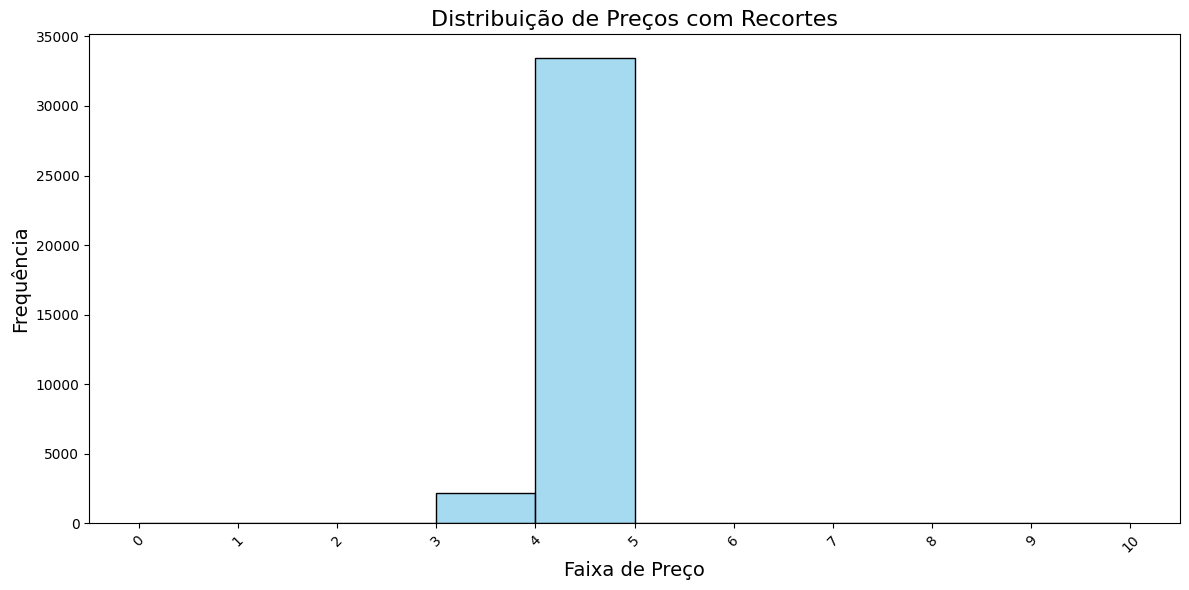

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir os intervalos de preço (bins) para o recorte
bins = [0, 1,2,3,4,5,6,7,8,9,10]

# Configurar o tamanho do gráfico
plt.figure(figsize=(12, 6))

# Plotar o histograma com recortes de preços
sns.histplot(df['log10_preco'], bins=bins, kde=False, color='skyblue', edgecolor='black')

# Adicionar rótulos e título
plt.title('Distribuição de Preços com Recortes', fontsize=16)
plt.xlabel('Faixa de Preço', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Marcar os valores das faixas de preço no eixo x
plt.xticks(bins, rotation=45)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


In [87]:
df.isna().sum()


log10_preco                    0
tipo_motor                     0
chassi_danificado              0
concessionaria_franchise       0
tipo_combustivel               0
tem_acidentes                  0
novo                           0
ano                            0
assentos_maximos               0
avaliacao_vendedor           384
log10_quilometragem         1618
log10_dias_no_mercado          0
log10_potencia              1932
dtype: int64

In [88]:
from sklearn.impute import KNNImputer

# Inicializar o imputador KNN
imputer = KNNImputer(n_neighbors=5)

# Aplicar o KNN Imputer aos dados
X_clustering_imputed = imputer.fit_transform(df)

# Convertendo de volta para DataFrame
X_clustering = pd.DataFrame(X_clustering_imputed, columns=df.columns)

# Verificar se ainda há valores faltantes
print(X_clustering.isnull().sum())


log10_preco                 0
tipo_motor                  0
chassi_danificado           0
concessionaria_franchise    0
tipo_combustivel            0
tem_acidentes               0
novo                        0
ano                         0
assentos_maximos            0
avaliacao_vendedor          0
log10_quilometragem         0
log10_dias_no_mercado       0
log10_potencia              0
dtype: int64


In [89]:
X_clustering

,log10_preco,tipo_motor,chassi_danificado,concessionaria_franchise,tipo_combustivel,tem_acidentes,novo,ano,assentos_maximos,avaliacao_vendedor,log10_quilometragem,log10_dias_no_mercado,log10_potencia
0,4.146066,2.0,0.0,0.0,4.0,0.0,0.0,2019.0,5.0,4.8,4.556905,1.653213,2.096910
1,4.268321,2.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,3.4,0.845098,1.623249,2.176091
2,4.255224,7.0,0.0,0.0,4.0,0.0,0.0,2003.0,4.0,4.6,4.954136,0.698970,2.281033
3,4.041353,2.0,0.0,0.0,4.0,0.0,0.0,2014.0,5.0,3.0,4.954517,1.653213,2.292256
4,3.889302,2.0,0.0,0.0,4.0,0.0,0.0,2012.0,5.0,4.6,4.983175,1.000000,2.149219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35650,4.642019,16.0,0.0,1.0,4.0,0.0,1.0,2020.0,6.0,3.8,0.000000,1.230449,2.551450
35651,4.408393,2.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,4.5,0.597533,1.204120,2.232996
35652,4.484001,0.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,4.6,0.000000,2.243038,2.184691
35653,4.041353,2.0,0.0,0.0,4.0,0.0,0.0,2018.0,5.0,3.7,4.555264,2.558709,2.170262


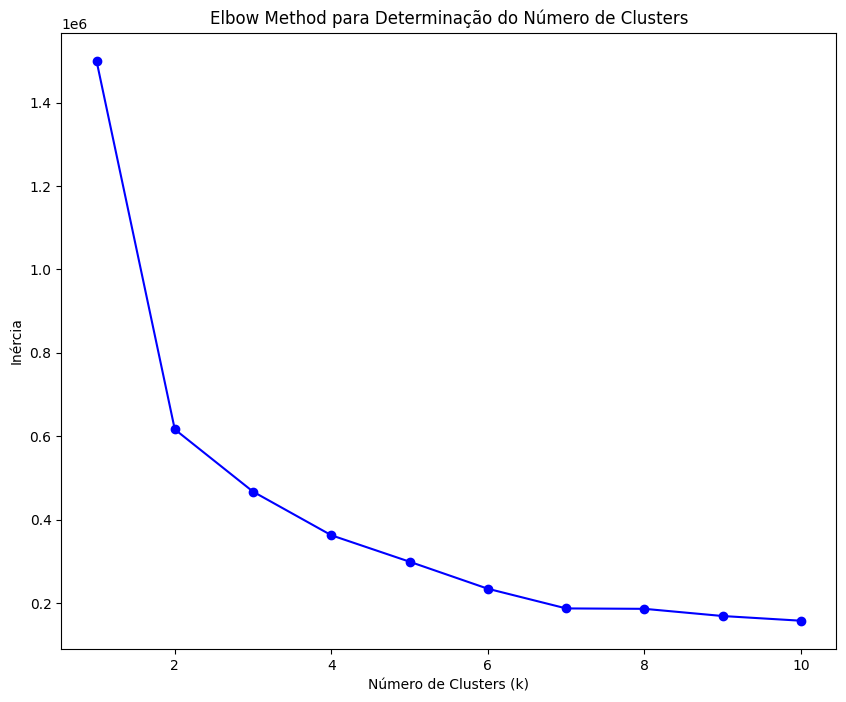

In [90]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Aplicar o Elbow Method
inertia = []
K = range(1, 11)  # Testar de 1 a 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_clustering)
    inertia.append(kmeans.inertia_)

# Plotar o Elbow Method
plt.figure(figsize=(10, 8))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Elbow Method para Determinação do Número de Clusters')
plt.show()


In [91]:
# Definir o número de clusters baseado no Elbow Method
k_optimal = 3

# Aplicar K-Means com o número ótimo de clusters
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans_optimal.fit_predict(X_clustering)

# Adicionar os clusters ao dataframe original
X_clustering['cluster'] = clusters

# Verificar a distribuição dos clusters
print(X_clustering['cluster'].value_counts())


cluster
0    13041
1    12793
2     9821
Name: count, dtype: int64


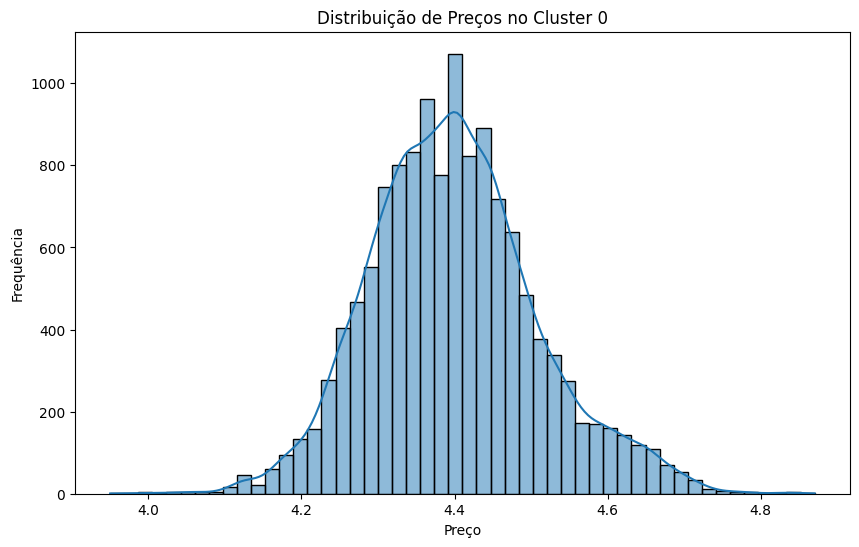

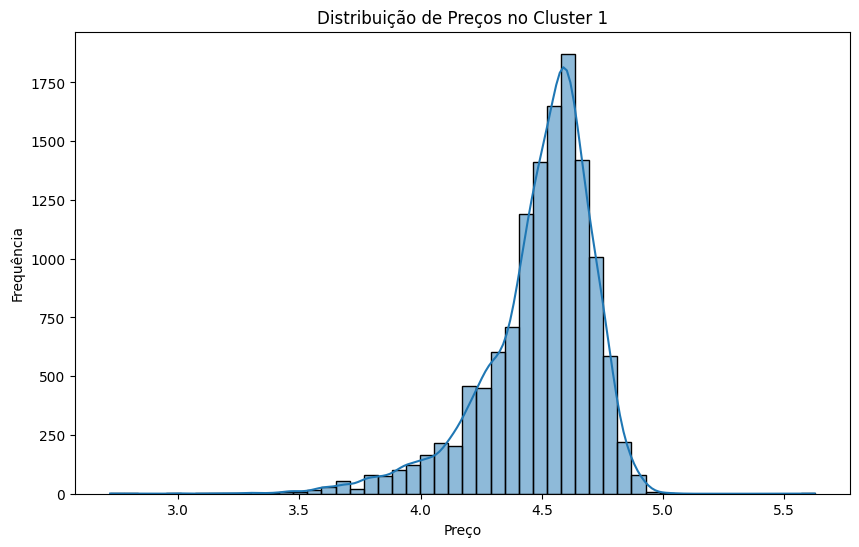

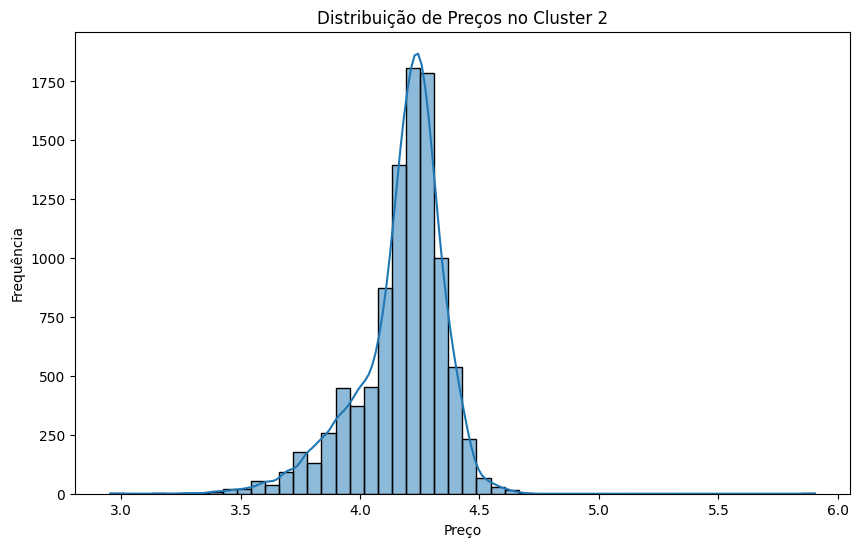

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verificar a distribuição de preços em cada cluster
for cluster_id in range(3):
    plt.figure(figsize=(10, 6))
    sns.histplot(X_clustering[X_clustering['cluster'] == cluster_id]['log10_preco'], bins=50, kde=True)
    plt.title(f'Distribuição de Preços no Cluster {cluster_id}')
    plt.xlabel('Preço')
    plt.ylabel('Frequência')
    plt.show()


In [93]:
X_clustering

,log10_preco,tipo_motor,chassi_danificado,concessionaria_franchise,tipo_combustivel,tem_acidentes,novo,ano,assentos_maximos,avaliacao_vendedor,log10_quilometragem,log10_dias_no_mercado,log10_potencia,cluster
0,4.146066,2.0,0.0,0.0,4.0,0.0,0.0,2019.0,5.0,4.8,4.556905,1.653213,2.096910,2
1,4.268321,2.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,3.4,0.845098,1.623249,2.176091,0
2,4.255224,7.0,0.0,0.0,4.0,0.0,0.0,2003.0,4.0,4.6,4.954136,0.698970,2.281033,2
3,4.041353,2.0,0.0,0.0,4.0,0.0,0.0,2014.0,5.0,3.0,4.954517,1.653213,2.292256,2
4,3.889302,2.0,0.0,0.0,4.0,0.0,0.0,2012.0,5.0,4.6,4.983175,1.000000,2.149219,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35650,4.642019,16.0,0.0,1.0,4.0,0.0,1.0,2020.0,6.0,3.8,0.000000,1.230449,2.551450,1
35651,4.408393,2.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,4.5,0.597533,1.204120,2.232996,0
35652,4.484001,0.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,4.6,0.000000,2.243038,2.184691,0
35653,4.041353,2.0,0.0,0.0,4.0,0.0,0.0,2018.0,5.0,3.7,4.555264,2.558709,2.170262,2


In [94]:
# Converter os clusters para dummies (One-Hot Encoding)
X_clustering = pd.get_dummies(X_clustering, columns=['cluster'])

In [95]:
X_clustering['cluster_0'] = X_clustering['cluster_0'].astype('int')
X_clustering['cluster_1'] = X_clustering['cluster_1'].astype('int')
X_clustering['cluster_2'] = X_clustering['cluster_2'].astype('int')

In [96]:
X_clustering

,log10_preco,tipo_motor,chassi_danificado,concessionaria_franchise,tipo_combustivel,tem_acidentes,novo,ano,assentos_maximos,avaliacao_vendedor,log10_quilometragem,log10_dias_no_mercado,log10_potencia,cluster_0,cluster_1,cluster_2
0,4.146066,2.0,0.0,0.0,4.0,0.0,0.0,2019.0,5.0,4.8,4.556905,1.653213,2.096910,0,0,1
1,4.268321,2.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,3.4,0.845098,1.623249,2.176091,1,0,0
2,4.255224,7.0,0.0,0.0,4.0,0.0,0.0,2003.0,4.0,4.6,4.954136,0.698970,2.281033,0,0,1
3,4.041353,2.0,0.0,0.0,4.0,0.0,0.0,2014.0,5.0,3.0,4.954517,1.653213,2.292256,0,0,1
4,3.889302,2.0,0.0,0.0,4.0,0.0,0.0,2012.0,5.0,4.6,4.983175,1.000000,2.149219,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35650,4.642019,16.0,0.0,1.0,4.0,0.0,1.0,2020.0,6.0,3.8,0.000000,1.230449,2.551450,0,1,0
35651,4.408393,2.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,4.5,0.597533,1.204120,2.232996,1,0,0
35652,4.484001,0.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,4.6,0.000000,2.243038,2.184691,1,0,0
35653,4.041353,2.0,0.0,0.0,4.0,0.0,0.0,2018.0,5.0,3.7,4.555264,2.558709,2.170262,0,0,1


In [97]:
import numpy as np

# Função para aplicar ruído gaussiano
def augment_with_gaussian_noise(df, numeric_cols, noise_factor=0.05):
    """
    Aplica ruído gaussiano nas colunas numéricas para aumentar o dataset.
    
    Parâmetros:
    df (pd.DataFrame): O DataFrame original.
    numeric_cols (list): Lista das colunas numéricas onde será adicionado o ruído.
    noise_factor (float): Fator que controla a magnitude do ruído gaussiano.
    
    Retorna:
    pd.DataFrame: DataFrame aumentado.
    """
    # Criar uma cópia do dataset original
    augmented_df = df.copy()
    
    # Gerar ruído gaussiano e adicionar às colunas numéricas selecionadas
    for col in numeric_cols:
        noise = np.random.randn(augmented_df.shape[0]) * noise_factor
        augmented_df[col] = augmented_df[col] + noise

    return augmented_df

# Definir as colunas numéricas onde será adicionado ruído gaussiano
numeric_cols = ['log10_quilometragem', 'log10_dias_no_mercado', 'log10_potencia', 'log10_preco']

# Aplicar o ruído gaussiano e criar a amostra aumentada
df_augmented = augment_with_gaussian_noise(X_clustering, numeric_cols)

# Concatenar o dataset original com a amostra aumentada para dobrar a base
df_final = pd.concat([X_clustering, df_augmented], ignore_index=True)

# Verificar a forma final do DataFrame após o augmentation
print(f"Amostra original: {X_clustering.shape[0]} linhas")
print(f"Amostra após augmentação: {df_final.shape[0]} linhas")


Amostra original: 35655 linhas
Amostra após augmentação: 71310 linhas


In [98]:
df_final

,log10_preco,tipo_motor,chassi_danificado,concessionaria_franchise,tipo_combustivel,tem_acidentes,novo,ano,assentos_maximos,avaliacao_vendedor,log10_quilometragem,log10_dias_no_mercado,log10_potencia,cluster_0,cluster_1,cluster_2
0,4.146066,2.0,0.0,0.0,4.0,0.0,0.0,2019.0,5.0,4.8,4.556905,1.653213,2.096910,0,0,1
1,4.268321,2.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,3.4,0.845098,1.623249,2.176091,1,0,0
2,4.255224,7.0,0.0,0.0,4.0,0.0,0.0,2003.0,4.0,4.6,4.954136,0.698970,2.281033,0,0,1
3,4.041353,2.0,0.0,0.0,4.0,0.0,0.0,2014.0,5.0,3.0,4.954517,1.653213,2.292256,0,0,1
4,3.889302,2.0,0.0,0.0,4.0,0.0,0.0,2012.0,5.0,4.6,4.983175,1.000000,2.149219,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71305,4.640937,16.0,0.0,1.0,4.0,0.0,1.0,2020.0,6.0,3.8,0.025135,1.262583,2.607619,0,1,0
71306,4.410975,2.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,4.5,0.596008,1.161450,2.253392,1,0,0
71307,4.471072,0.0,0.0,1.0,4.0,0.0,1.0,2020.0,5.0,4.6,0.022463,2.224499,2.212418,1,0,0
71308,4.034812,2.0,0.0,0.0,4.0,0.0,0.0,2018.0,5.0,3.7,4.654385,2.581814,2.230911,0,0,1


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# 1. Dividir o conjunto de dados em treinamento e teste/validação
X_train, X_test, y_train, y_test = train_test_split(X_clustering.drop(columns=['log10_preco']), 
                                                    X_clustering['log10_preco'], 
                                                    test_size=0.2, 
                                                    random_state=42)




Epoch [1/150], Loss: 0.6535
Epoch [10/150], Loss: 0.0259
Epoch [20/150], Loss: 0.0270
Epoch [30/150], Loss: 0.0252
Epoch [40/150], Loss: 0.0244
Epoch [50/150], Loss: 0.0226
Epoch [60/150], Loss: 0.0230
Epoch [70/150], Loss: 0.0228
Epoch [80/150], Loss: 0.0230
Epoch [90/150], Loss: 0.0227
Epoch [100/150], Loss: 0.0290
Epoch [110/150], Loss: 0.0218
Epoch [120/150], Loss: 0.0224
Epoch [130/150], Loss: 0.0220
Epoch [140/150], Loss: 0.0218
Epoch [150/150], Loss: 0.0218


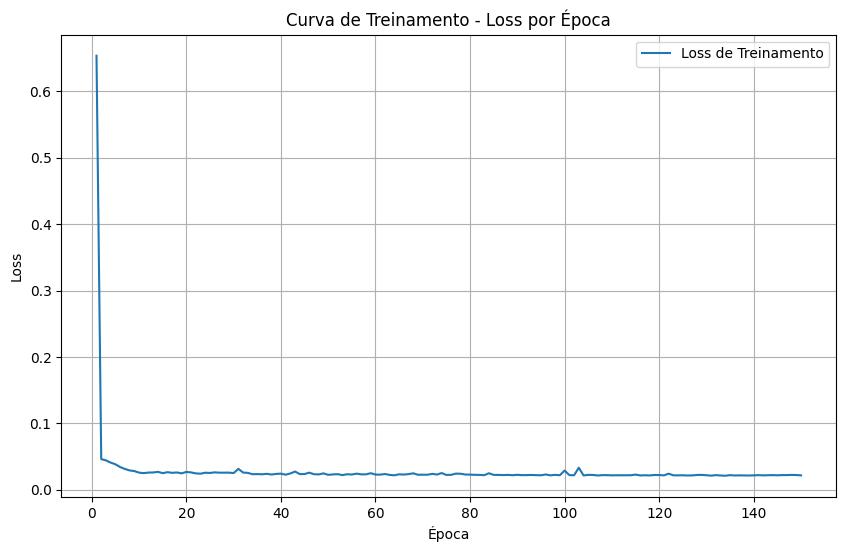

MSE: 0.0219, R²: 0.5397, MAE: 0.1144, RMSE: 0.1480


In [100]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Definir a rede neural
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetworkModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

def train_neural_network(X_train, y_train, input_dim, epochs=150, batch_size=256, learning_rate=0.001):
    # Converter o DataFrame para numpy.ndarray
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model = NeuralNetworkModel(input_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lista para armazenar o loss por época
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        epoch_loss /= len(train_loader.dataset)
        losses.append(epoch_loss)  # Armazena o loss da época atual
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')
    
    # Plotar o gráfico de Loss por época
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), losses, label='Loss de Treinamento')
    plt.title('Curva de Treinamento - Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return model

# Repetir a conversão do DataFrame para numpy e treinar o modelo
input_dim = X_train.shape[1]
model_with_clusters = train_neural_network(X_train, y_train, input_dim)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def evaluate_model(model, X_test, y_test):
    model.eval()
    # Converter o DataFrame para numpy.ndarray
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = mean_squared_error(y_test_tensor.numpy(), predictions.numpy())
        mae = mean_absolute_error(y_test_tensor.numpy(), predictions.numpy())
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_tensor.numpy(), predictions.numpy())
        print(f'MSE: {mse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# Avaliar o modelo que usa os clusters como feature adicional
evaluate_model(model_with_clusters, X_test, y_test)


In [133]:
# 1. Amostragem de 100 mil linhas
df_teste = df_1.sample(n=50000, random_state=32)

In [134]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import RareLabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

initial_cols = ['price', 'body_type', 'city', 'daysonmarket', 'engine_type', 'exterior_color', 
                 'frame_damaged', 'franchise_dealer', 'fuel_type', 'has_accidents', 
                 'horsepower', 'interior_color', 'is_new', 'year', 'major_options', 
                 'make_name', 'model_name', 'maximum_seating', 'mileage', 'seller_rating', 
                 'theft_title', 'torque', 'transmission_display', 'trim_name', 'wheel_system_display']
df_teste = df_teste
                
item0 = df_teste.shape[0]  
df_teste = df_teste.drop_duplicates()  
item1 = df_teste.shape[0]  
print(f"There are {item0-item1} duplicates found in the dataset")  


df_teste = df_teste[df_teste['price']>0]


df_teste['log10_price'] = df_teste['price'].apply(lambda x: np.log10(x))


for col in ['exterior_color', 'interior_color', 'make_name', 'model_name']:
    df_teste[col] = df_teste[col].fillna('None').str.lower()


df_teste['model'] = df_teste['make_name'] + ' ' + df_teste['model_name']



selected_cols = ['log10_price', 'model', 'body_type', 'city', 'daysonmarket', 'engine_type', 
                 'exterior_color', 'frame_damaged', 'franchise_dealer', 'fuel_type', 'has_accidents', 
                 'horsepower', 'interior_color', 'is_new', 'year', 'major_options', 
                 'maximum_seating', 'mileage', 'seller_rating', 
                 'theft_title', 'torque', 'transmission_display', 'trim_name', 
                 'wheel_system_display']
df_teste = df_teste[selected_cols]


There are 0 duplicates found in the dataset


In [135]:
# Função para log-transform das colunas numéricas
def log10_transform(x):
    try:
        return np.log10(x + 1)
    except:
        return np.nan

# Função para bin-transform da coluna seller_rating
def bin_transform(x):
    try:
        return round(1/10 * round(x * 10), 1)
    except:
        return np.nan

# Aplicar log10-transform nas colunas numéricas
for col in ['mileage', 'daysonmarket', 'horsepower']:
    df_teste[f'log10_{col}'] = df_teste[col].apply(log10_transform)
    df_teste = df_teste.drop([col], axis=1)

# Aplicar bin-transform na coluna seller_rating
df_teste['seller_rating'] = df_teste['seller_rating'].apply(bin_transform)

# Remover colunas irrelevantes
cols2drop = ['major_options', 'torque']
df_teste = df_teste.drop(cols2drop, axis=1)

# Aplicar RareLabelEncoder nas colunas categóricas
for col in df_teste.columns:
    if col != 'log10_price' and df_teste[col].dtype == 'object':
        df_teste[col] = df_teste[col].fillna('None').astype(str)
        encoder = RareLabelEncoder(n_categories=1, max_n_categories=150, replace_with='Other', tol=50/df_teste.shape[0])
        df_teste[col] = encoder.fit_transform(df_teste[[col]])

# Exibir a forma do DataFrame pós-transformação
print(df_teste.shape)
print(df_teste.head())


(50000, 22)
         log10_price             model        body_type       city  \
845810      4.317687     dodge journey  SUV / Crossover      Other   
1746700     4.324488    chevrolet trax  SUV / Crossover  Lafayette   
941152      4.333125  volkswagen jetta            Sedan      Other   
930237      4.342403       ford fusion            Sedan      Other   
653384      4.483016  subaru crosstrek  SUV / Crossover      Other   

        engine_type         exterior_color frame_damaged  franchise_dealer  \
845810           I4  pitch black clearcoat         False              True   
1746700          I4  mosaic black metallic          None              True   
941152           I4             pure white          None              True   
930237           I4            agate black         False              True   
653384           H4                  Other          None              True   

        fuel_type has_accidents  ...  year  maximum_seating  seller_rating  \
845810   Gasoline   

In [136]:
# Aplicar a função para remover linhas com 'Other'
df_teste = drop_other_rows(df_teste)

# Exibir a forma do DataFrame pós-transformação
print(df_teste.shape)
print(df_teste.head())

(5574, 22)
         log10_price           model        body_type         city  \
1746700     4.324488  chevrolet trax  SUV / Crossover    Lafayette   
2356120     4.219506   nissan altima            Sedan  San Antonio   
967312      4.219323    toyota camry            Sedan    Charlotte   
2924701     4.402003   nissan altima            Sedan  Los Angeles   
347484      4.307218     ford fusion            Sedan    Baltimore   

        engine_type         exterior_color frame_damaged  franchise_dealer  \
1746700          I4  mosaic black metallic          None              True   
2356120          I4          glacier white         False              True   
967312           I4            super white         False              True   
2924701          I4          glacier white          None              True   
347484           I4               magnetic          None              True   

        fuel_type has_accidents  ...  year  maximum_seating  seller_rating  \
1746700  Gasoline    

In [137]:
df_teste = df_teste.drop(['model','city','exterior_color','interior_color','trim_name','transmission_display','theft_title','wheel_system_display', 'body_type'], axis=1)


In [138]:
# Aplicar a função à coluna 'maximum_seating' para transformar em inteiro
df_teste['maximum_seating'] = df_teste['maximum_seating'].apply(extract_seating)

# Verificar se a conversão foi bem-sucedida
print(df_teste['maximum_seating'].head())

# Opcional: Imputar valores faltantes (NaN) se houver algum
df_teste['maximum_seating'].fillna(df_teste['maximum_seating'].median(), inplace=True)

# Verificar novamente a coluna
print(df_teste['maximum_seating'].head())


1746700    5.0
2356120    5.0
967312     5.0
2924701    5.0
347484     5.0
Name: maximum_seating, dtype: float64
1746700    5.0
2356120    5.0
967312     5.0
2924701    5.0
347484     5.0
Name: maximum_seating, dtype: float64


In [139]:
from sklearn.preprocessing import LabelEncoder

# 1. Aplicar Label Encoding nas colunas categóricas 'engine_type' e 'fuel_type'
label_encoder = LabelEncoder()

for col in ['engine_type', 'fuel_type']:
    df_teste[col] = label_encoder.fit_transform(df_teste[col].astype(str))

# Verificar a transformação
print(df_teste[['engine_type', 'fuel_type']].head())




         engine_type  fuel_type
1746700            2          4
2356120            2          4
967312             2          4
2924701            2          4
347484             2          4


In [140]:
# 2. Converter colunas booleanas (True/False) para 0 e 1
boolean_cols = ['franchise_dealer', 'is_new']
df_teste[boolean_cols] = df_teste[boolean_cols].astype(int)

# Verificar as colunas transformadas
print(df_teste[boolean_cols].head())

# Exibir a forma do DataFrame pós-transformação
print(df_teste.shape)

         franchise_dealer  is_new
1746700                 1       1
2356120                 1       0
967312                  1       0
2924701                 1       1
347484                  1       1
(5574, 13)


In [141]:
import numpy as np

# Função para converter 'True' em 1, 'False' em 0, e 'None' em NaN
def boolean_transform(value):
    if value == 'True':
        return 1
    elif value == 'False':
        return 0
    else:
        return np.nan  # Mantém o valor como NaN se for None

# Aplicar a transformação para as colunas 'frame_damaged' e 'has_accidents'
for col in ['frame_damaged', 'has_accidents']:
    df_teste[col] = df_teste[col].apply(boolean_transform)

# Verificar as primeiras linhas das colunas transformadas
print(df_teste[['frame_damaged', 'has_accidents']].head())

# Opcional: Imputar os valores NaN posteriormente
# Aqui podemos preencher os valores faltantes (NaN) com a moda (valor mais frequente)
df_teste['frame_damaged'].fillna(df_teste['frame_damaged'].mode()[0], inplace=True)
df_teste['has_accidents'].fillna(df_teste['has_accidents'].mode()[0], inplace=True)

# Verificar novamente após preenchimento de NaNs
print(df_teste[['frame_damaged', 'has_accidents']].head())


         frame_damaged  has_accidents
1746700            NaN            NaN
2356120            0.0            0.0
967312             0.0            1.0
2924701            NaN            NaN
347484             NaN            NaN
         frame_damaged  has_accidents
1746700            0.0            0.0
2356120            0.0            0.0
967312             0.0            1.0
2924701            0.0            0.0
347484             0.0            0.0


In [142]:
# Dicionário de mapeamento para renomear as colunas
colunas_renomeadas = {
    'log10_price': 'log10_preco',
    'body_type': 'tipo_carroceria',
    'engine_type': 'tipo_motor',
    'frame_damaged': 'chassi_danificado',
    'franchise_dealer': 'concessionaria_franchise',
    'fuel_type': 'tipo_combustivel',
    'has_accidents': 'tem_acidentes',
    'is_new': 'novo',
    'year': 'ano',
    'maximum_seating': 'assentos_maximos',
    'seller_rating': 'avaliacao_vendedor',
    'theft_title': 'titulo_furto',
    'wheel_system_display': 'sistema_roda',
    'log10_mileage': 'log10_quilometragem',
    'log10_daysonmarket': 'log10_dias_no_mercado',
    'log10_horsepower': 'log10_potencia'
}

# Aplicar a renomeação ao DataFrame
df_teste = df_teste.rename(columns=colunas_renomeadas)

# Verificar as primeiras linhas após a renomeação
df_teste


,log10_preco,tipo_motor,chassi_danificado,concessionaria_franchise,tipo_combustivel,tem_acidentes,novo,ano,assentos_maximos,avaliacao_vendedor,log10_quilometragem,log10_dias_no_mercado,log10_potencia
1746700,4.324488,2,0.0,1,4,0.0,1,2020,5.0,4.6,0.602060,1.462398,2.143015
2356120,4.219506,2,0.0,1,4,0.0,0,2019,5.0,4.6,4.597618,1.544068,2.276462
967312,4.219323,2,0.0,1,4,1.0,0,2018,5.0,4.2,4.709448,1.414973,2.309630
2924701,4.402003,2,0.0,1,4,0.0,1,2020,5.0,3.8,0.698970,2.450249,2.276462
347484,4.307218,2,0.0,1,4,0.0,1,2020,5.0,4.2,0.000000,1.886491,2.245513
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270796,4.407306,2,0.0,1,4,0.0,1,2020,5.0,NaN,0.845098,1.986772,2.232996
233218,4.418666,2,0.0,1,4,0.0,1,2020,5.0,4.5,1.041393,2.352183,2.260071
2239655,4.037387,2,0.0,0,4,0.0,0,2019,5.0,3.2,4.496293,1.924279,2.117271
2609246,4.317123,2,0.0,1,4,0.0,1,2020,5.0,4.8,1.000000,2.053078,2.170262


In [143]:
from sklearn.impute import KNNImputer

# Inicializar o imputador KNN
imputer = KNNImputer(n_neighbors=5)

# Aplicar o KNN Imputer aos dados
X_clustering_imputed = imputer.fit_transform(df_teste)

# Convertendo de volta para DataFrame
X_clustering = pd.DataFrame(X_clustering_imputed, columns=df_teste.columns)

# Verificar se ainda há valores faltantes
print(X_clustering.isnull().sum())


log10_preco                 0
tipo_motor                  0
chassi_danificado           0
concessionaria_franchise    0
tipo_combustivel            0
tem_acidentes               0
novo                        0
ano                         0
assentos_maximos            0
avaliacao_vendedor          0
log10_quilometragem         0
log10_dias_no_mercado       0
log10_potencia              0
dtype: int64


In [144]:
# Definir o número de clusters baseado no Elbow Method
k_optimal = 3

# Aplicar K-Means com o número ótimo de clusters
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans_optimal.fit_predict(X_clustering)

# Adicionar os clusters ao dataframe original
X_clustering['cluster'] = clusters

# Verificar a distribuição dos clusters
print(X_clustering['cluster'].value_counts())


cluster
0    2006
1    1985
2    1583
Name: count, dtype: int64


In [145]:
# Converter os clusters para dummies (One-Hot Encoding)
X_clustering = pd.get_dummies(X_clustering, columns=['cluster'])

In [146]:
X_clustering['cluster_0'] = X_clustering['cluster_0'].astype('int')
X_clustering['cluster_1'] = X_clustering['cluster_1'].astype('int')
X_clustering['cluster_2'] = X_clustering['cluster_2'].astype('int')

In [147]:
import pandas as pd

# Certifique-se de que o modelo está em modo de avaliação
model_with_clusters.eval()

# Gerar previsões para o conjunto de teste
with torch.no_grad():
    y_pred_tensor = model_with_clusters(torch.tensor(X_test.values, dtype=torch.float32))
    y_pred = y_pred_tensor.numpy()

# Criar um dataframe com os valores reais e previstos
df_comparacao = pd.DataFrame({
    'Valor Real': y_test.values,
    'Valor Previsto': y_pred.flatten()
})

# Exibir as primeiras linhas do dataframe para inspeção
print(df_comparacao.head())


   Valor Real  Valor Previsto
0    4.421620        4.255837
1    4.379360        4.389906
2    4.408766        4.370646
3    4.566920        4.388630
4    4.416840        4.510720


In [150]:
# Separar as features (X) e a variável alvo (y) real
X_novo_sample = X_clustering.drop(columns=['log10_preco'])
y_real_novo_sample = X_clustering['log10_preco']

# Converter o DataFrame para um array NumPy antes de criar o tensor
X_novo_sample_np = X_novo_sample.to_numpy()

# Fazer previsões com o modelo treinado
model_with_clusters.eval()  # Colocar o modelo em modo de avaliação
with torch.no_grad():
    y_pred_tensor = model_with_clusters(torch.tensor(X_novo_sample_np, dtype=torch.float32))
    y_pred_novo_sample = y_pred_tensor.numpy().flatten()

# Reverter a transformação logarítmica (10^valor)
y_real_novo_sample_real = 10 ** y_real_novo_sample  # Reverter log10 para valor real
y_pred_novo_sample_real = 10 ** y_pred_novo_sample  # Reverter log10 para valor real

# Comparar os valores reais com os valores previstos (em escala original)
df_comparacao = pd.DataFrame({
    'Valor Real': y_real_novo_sample_real.values,
    'Valor Previsto': y_pred_novo_sample_real
})

# Exibir as primeiras linhas da comparação
print(df_comparacao.head())


   Valor Real  Valor Previsto
0     21110.0    23955.357422
1     16577.0    15918.176758
2     16570.0    12597.920898
3     25235.0    22526.664062
4     20287.0    25384.419922


In [152]:
df_comparacao

,Valor Real,Valor Previsto
0,21110.0,23955.357422
1,16577.0,15918.176758
2,16570.0,12597.920898
3,25235.0,22526.664062
4,20287.0,25384.419922
...,...,...
5569,25545.0,22356.207031
5570,26222.0,22152.085938
5571,10899.0,11479.026367
5572,20755.0,22500.240234


In [154]:
import numpy as np

# Calcular a diferença absoluta entre os valores reais e previstos
df_comparacao['Diferenca Absoluta'] = np.abs(df_comparacao['Valor Real'] - df_comparacao['Valor Previsto'])

# Calcular a média da diferença
media_diferenca = df_comparacao['Diferenca Absoluta'].mean()

print(f'Diferença média (erro absoluto médio) entre os valores reais e previstos: {media_diferenca:.2f}')


Diferença média (erro absoluto médio) entre os valores reais e previstos: 6606.56


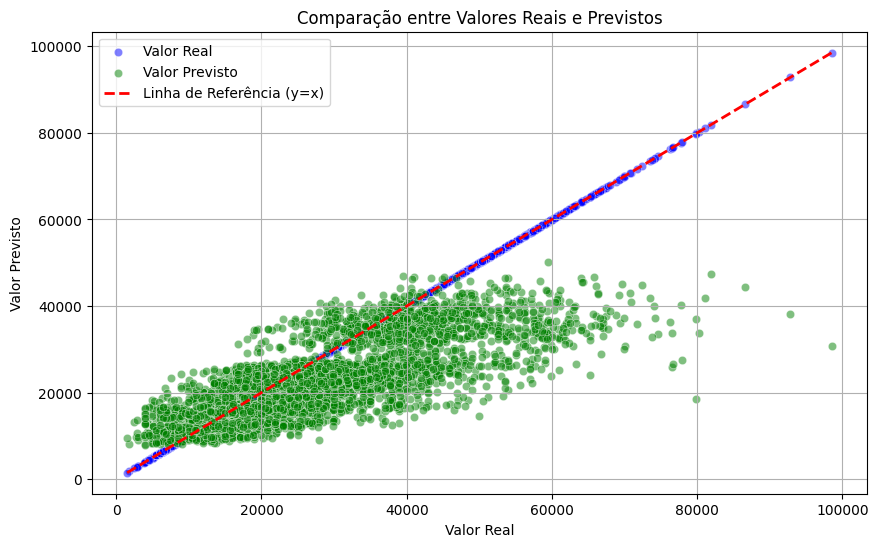

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar um scatter plot para visualizar a comparação
plt.figure(figsize=(10, 6))

# Plotar os valores reais em azul
sns.scatterplot(x='Valor Real', y='Valor Real', data=df_comparacao, alpha=0.5, color='blue', label='Valor Real')

# Plotar os valores previstos em verde
sns.scatterplot(x='Valor Real', y='Valor Previsto', data=df_comparacao, alpha=0.5, color='green', label='Valor Previsto')

# Adicionar uma linha y=x para referência
plt.plot([df_comparacao['Valor Real'].min(), df_comparacao['Valor Real'].max()], 
         [df_comparacao['Valor Real'].min(), df_comparacao['Valor Real'].max()], 
         color='red', lw=2, linestyle='--', label='Linha de Referência (y=x)')

plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()
plt.grid(True)
plt.show()


# Projeto de Regressão Linear com Deep Learning e Data Augmentation
## Passo 1: Carregamento e Amostragem dos Dados
* Carreguei o dataset de carros usados e realizamos uma amostragem de 300 mil linhas para o treinamento do modelo. Além disso, foram removidas duplicatas para garantir que o dataset seja único.

```python
df_1 = pd.read_csv(r'C:\Users\filip\Downloads\archive\used_cars_data.csv')
sample_df = df_1.sample(n=300000, random_state=42)
df = sample_df.drop_duplicates()


# Passo 2: Pré-processamento dos Dados
* Removi linhas com preços menores ou iguais a zero e transformamos a variável price em logaritmo (log10) para melhorar a linearidade do modelo de regressão.
* Colunas como make_name e model_name foram combinadas em uma única coluna chamada model.

```python
df = df[df['price'] > 0]
df['log10_price'] = df['price'].apply(lambda x: np.log10(x))
df['model'] = df['make_name'] + ' ' + df['model_name']


# Passo 3: Transformações nas Colunas Numéricas
* Apliquei a transformação logarítmica (log10) nas colunas numéricas como mileage, daysonmarket, e horsepower para corrigir distribuições enviesadas.
* A coluna seller_rating foi ajustada utilizando uma transformação binária.
```python
for col in ['mileage', 'daysonmarket', 'horsepower']:
    df[f'log10_{col}'] = df[col].apply(log10_transform)
df['seller_rating'] = df['seller_rating'].apply(bin_transform)


# Passo 4: Codificação de Categorias Raras
* Usei RareLabelEncoder para substituir categorias raras nas colunas categóricas por "Other", a fim de reduzir o impacto de categorias muito pequenas no treinamento.
```python
for col in df.columns:
    if col != 'log10_price' and df[col].dtype == 'object':
        df[col] = df[col].fillna('None').astype(str)
        encoder = RareLabelEncoder(n_categories=1, max_n_categories=150, replace_with='Other', tol=50/df.shape[0])
        df[col] = encoder.fit_transform(df[[col]])


# Passo 5: Limpeza de Colunas Desnecessárias
* Colunas como model, city, exterior_color, entre outras, foram removidas por não serem relevantes para o modelo de regressão.
```python
df = df.drop(['model', 'city', 'exterior_color', 'interior_color', 'trim_name', 'transmission_display', 'theft_title', 'wheel_system_display', 'body_type'], axis=1)


# Passo 6: Codificação de Variáveis Booleanas e Categóricas
* Variáveis booleanas foram transformadas para valores 0 e 1, e colunas categóricas como engine_type e fuel_type foram codificadas usando LabelEncoder.
```python
label_encoder = LabelEncoder()
for col in ['engine_type', 'fuel_type']:
    df[col] = label_encoder.fit_transform(df[col].astype(str))
boolean_cols = ['franchise_dealer', 'is_new']
df[boolean_cols] = df[boolean_cols].astype(int)


# Passo 7: Preenchimento de Valores Nulos
* Utilizei o KNNImputer para preencher valores faltantes com base nos k-vizinhos mais próximos.
```python
imputer = KNNImputer(n_neighbors=5)
X_clustering_imputed = imputer.fit_transform(df)
X_clustering = pd.DataFrame(X_clustering_imputed, columns=df.columns)


# Passo 8: Clusterização com K-Means
* Apliquei o método do cotovelo (Elbow Method) para determinar o número ótimo de clusters e segmentamos os dados em 3 clusters utilizando K-Means.
```python
k_optimal = 3
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans_optimal.fit_predict(X_clustering)
X_clustering['cluster'] = clusters


# Passo 9: Aumento de Dados com Ruído Gaussiano
* Para aumentar a amostra de dados, aplicamos ruído gaussiano controlado nas colunas numéricas. A amostra aumentada foi concatenada com a amostra original para dobrar o tamanho do dataset.
```python
df_augmented = augment_with_gaussian_noise(X_clustering, ['log10_quilometragem', 'log10_dias_no_mercado', 'log10_potencia', 'log10_preco'])
df_final = pd.concat([X_clustering, df_augmented], ignore_index=True)


# Passo 10: Divisão dos Dados e Treinamento da Rede Neural
* Dividi os dados em conjunto de treino e teste. Em seguida, treinei uma rede neural profunda com várias camadas densas para prever o preço dos carros.
```python
X_train, X_test, y_train, y_test = train_test_split(X_clustering.drop(columns=['log10_preco']), X_clustering['log10_preco'], test_size=0.2, random_state=42)
model_with_clusters = train_neural_network(X_train, y_train, input_dim)


# Passo 11: Avaliação do Modelo
* Avaliei o desempenho do modelo em termos de erro quadrático médio (MSE), erro absoluto médio (MAE), e coeficiente de determinação (R²).
```python
evaluate_model(model_with_clusters, X_test, y_test)

* Resultando em MSE: 0.0219, R²: 0.5397, MAE: 0.1144, RMSE: 0.1480, o que é uma grande melhora comparada a versão passada em que a melhor Loss ficou em 13 Mil

# Passo 12: Previsão com Novo Sample
* Carreguei um novo conjunto de dados, aplicando o mesmo pré-processamento, e usei o modelo treinado para prever os preços dos carros.
```python
model_with_clusters.eval()
with torch.no_grad():
    y_pred_tensor = model_with_clusters(torch.tensor(X_novo_sample_np, dtype=torch.float32))
    y_pred_novo_sample = y_pred_tensor.numpy().flatten()
df_comparacao = pd.DataFrame({'Valor Real': y_real_novo_sample_real.values, 'Valor Previsto': y_pred_novo_sample_real})


# Passo 13: Visualização dos Resultados
* Visualizamos a comparação entre os valores reais e os previstos por meio de um gráfico de dispersão.
```python
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Valor Real', y='Valor Real', data=df_comparacao, alpha=0.5, color='blue', label='Valor Real')
sns.scatterplot(x='Valor Real', y='Valor Previsto', data=df_comparacao, alpha=0.5, color='green', label='Valor Previsto')
plt.plot([df_comparacao['Valor Real'].min(), df_comparacao['Valor Real'].max()], 
         [df_comparacao['Valor Real'].min(), df_comparacao['Valor Real'].max()], 
         color='red', lw=2, linestyle='--', label='Linha de Referência (y=x)')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()
plt.grid(True)
plt.show()
